**Chris Gray | Group 15 | 10185372 | 14cmg5**

In [1]:
!pip install tensorflow-gpu==2.0.0rc numpy pandas folium --no-cache-dir

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import folium
import datetime as dt
import dateutil.parser
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
tf.__version__

'2.0.0-rc0'

In [0]:
#------------------------------------------------------------------------------#
#                               Data Processing                                #



# This is an object class to store all the data about storms :) 
class storm(object):

  def __init__(self,name,sid,lat,longi,basin,sub_basin,times,wind,pres): 
    # Note: the lat, long, times, wind, and pres are all arrays across the duration of a storm! 
    self.sid = sid # unique ID number associated with year/number of storm 
    self.name = name # Hurricane Name
    self.lat = lat # Hurricane Latitude, array of all 
    self.longi = longi # Hurricane Longitude, array of all 
    self.basin = basin # Hurricane basin, by 2-lettter code 
    self.sub_basin = sub_basin
    self.times = times #Hurricane times 
    self.wind = wind 
    self.pres = pres

  def Get_Maxs(this):
    maxLat = max(this.lat)
    maxLong = max(this.longi)
    maxWind = max(this.wind)
    maxPres = max(this.pres)
    return maxLat, maxLong, maxWind, maxPres

  def Get_Mins(this):
    minLat = min(this.lat)
    minLong = min(this.longi)
    minWind = min(this.wind)
    minPres = min(this.pres)
    return minLat, minLong, minWind, minPres

  # remove data points thar are not in the specified time interval 
  def CleanStorm(this,interval):
    toRemove = []
    i = 1
    lastCleanTime = this.times[0]
    # check if the last correct time minus the current time is in the correct interval
    while(i < len(this.times)):
      nextTime = this.times[i]
      tDelta = nextTime - lastCleanTime
      if tDelta == interval:
        lastCleanTime = nextTime
      else:
        toRemove.append(i)
      i += 1

    # reverse sort to not mess up the indices 
    toRemove.sort(reverse=True)

    # Remove the bad data
    for r in toRemove:
      this.times.pop(r)
      this.longi.pop(r)
      this.lat.pop(r)
      this.wind.pop(r)
      this.pres.pop(r)      

# This function sorts imported data into storms :) 
def stormify(dataset):
  storm_list = []
  item = dataset[0] 

  stormno = item[2]
  name = item[5] 
  sid = str(item[1]*1000 + item[2])
  lat = []
  longi = []
  basin = str.strip(item[3])
  sub_basin = str.strip(item[4])
  times = []
  wind = []
  pres = []
  for item in dataset: 
    # Case 1 - New storm 
    # Create an object for the old storm, re-initialize everything 
    if (item[2] != stormno):
      # Create an object for the given SID 
      storm_list.append(storm(name, sid, lat, longi, basin,sub_basin, times, wind, pres))
      # Reset Values with new data
      stormno = item[2]
      name = item[5] 
      sid = str(item[1]*1000 + item[2])
      lat = [item[8]]
      longi = [item[9]]
      basin = str.strip(item[3])
      sub_basin = str.strip(item[4])
      times = [dateutil.parser.parse(item[6])]
      wind = [item[10]]
      pres = [item[11]]
    # Case 2 - Same old storm 
    else:
      lat.append(item[8])
      longi.append(item[9])
      times.append(dateutil.parser.parse(item[6]))
      wind.append(item[10])
      pres.append(item[11])

  return storm_list

def normalize(x, mx, mn):
  return (x-mn)/(mx-mn)

def normalize_col(col,maxV,minV):
  for i in range(len(col)):
    col[i] = normalize(col[i],maxV,minV)
  return col

def normalize_storms(storms):
  maxLats = []
  maxLongs = []
  maxWinds = []
  maxPress = []

  minLats = []
  minLongs = []
  minWinds = []
  minPress = []

  for s in storms:
    maLa , maLo , maWi, maPr = s.Get_Maxs()
    maxLats.append(maLa)
    maxLongs.append(maLo)
    maxWinds.append(maWi)
    maxPress.append(maPr)

    miLa, miLo, miWi, miPr = s.Get_Mins()
    minLats.append(miLa)
    minLongs.append(miLo)
    minWinds.append(miWi)
    minPress.append(miPr)

  maxs = [max(maxLats),max(maxLongs),max(maxWinds),max(maxPress)]
  mins = [min(minLats),min(minLongs),min(minWinds),min(minPress)]

  for s in storms:
    s.lat = normalize_col(s.lat,maxs[0],mins[0])
    s.longi = normalize_col(s.longi,maxs[1],mins[1])
    s.wind = normalize_col(s.wind,maxs[2],mins[2])
    s.pres = normalize_col(s.pres,maxs[3],mins[3])

  return storms, maxs, mins

def remove_small_storms(storm_list,cutoff):
  refined_storms = []
  for storm in storm_list:
    if len(storm.longi) >= cutoff:
      refined_storms.append(storm)
  return refined_storms 

# Get sequences of inputs and labels for each variable
def get_orgnaised_storm(storm,size):
  datas = []
  labels_lat = []
  labels_long = []
  labels_wind = []
  labels_pres = []

  lats = storm.lat
  longs = storm.longi

  winds = storm.wind
  press = storm.pres
  
  length = len(winds)
  for i in range((length+1)-size):
    new_data = []
    for j in range(size-1):
      index = j + i
   
      new_data.append(lats[index])
      new_data.append(longs[index])

      new_data.append(winds[index])
      new_data.append(press[index])

    label_index = index + 1

    datas.append(new_data)
    labels_lat.append(lats[label_index])
    labels_long.append(longs[label_index])
    labels_wind.append(winds[label_index])
    labels_pres.append(press[label_index])

  return datas, labels_lat, labels_long, labels_wind, labels_pres

# Get sequences of inputs and labels for each variable
def create_organised_data(storm_list, stormSize):
  data_x      = [] # lat_t0|long_t0|wnd_t0|pres_t0|lat_t1|long_t1|wnd_t1|pres_t1|...
  data_y_lat  = [] # lat at next interval 
  data_y_long = []
  data_y_wind = []
  data_y_pres = []

  for storm in storm_list:
    x, yLat, yLong, yWind, yPres = get_orgnaised_storm(storm,stormSize)
    data_x = data_x + x
    data_y_lat = data_y_lat + yLat
    data_y_long = data_y_long + yLong
    data_y_wind = data_y_wind + yWind
    data_y_pres = data_y_pres + yPres

  return np.array(data_x), np.array(data_y_lat), np.array(data_y_long), np.array(data_y_wind), np.array(data_y_pres)

# get 4 time intervals as input and the next 4 as output
def get_48h_of_storms(storm):
  input_size = 4
  output_size = 4

  datas = []
  labels = []

  lats = storm.lat
  longs = storm.longi

  winds = storm.wind
  press = storm.pres
  
  length = len(winds)
  for i in range((length+1)-input_size-output_size):
    new_data = []
    new_label = []
    # get inputs
    for j in range(i,i+input_size):
      index = j

      new_data.append(lats[index])
      new_data.append(longs[index])

      new_data.append(winds[index])
      new_data.append(press[index])

    label_index = index

    # get matching output
    for k in range(output_size):
      label_index = label_index + 1
      sub_label = []
      
      sub_label.append(lats[label_index])
      sub_label.append(longs[label_index])

      sub_label.append(winds[label_index])
      sub_label.append(press[label_index])
      
      new_label.append(sub_label)

    datas.append(new_data)
    labels.append(new_label)

  return datas, labels

# get 24 hours of input and the following 48 hours of output
def create_48h_of_storm_data(storms):
  data_x = []
  data_y = []

  for storm in storms:
    xs , ys = get_48h_of_storms(storm)
    data_x = data_x + xs
    data_y = data_y + ys

  return data_x, data_y

#------------------------------------------------------------------------------#






#------------------------------------------------------------------------------#
#                                   Models                                     #

# model made of of the 4 other models 
class Meta_Model:
  def __init__(self,lat_model, long_model, wind_model, pres_model):
    self.lat_model = lat_model
    self.long_model = long_model
    self.wind_model = wind_model
    self.pres_model = pres_model

  def predict24h(self,data):
    preds = []
    for i in range(4):
      pred = self.predict6h(data)
      preds.append(pred)
      data = np.append(data[4:],pred)
    return preds

  def predict6h(self,data):
    lat = self.lat_model.Predict(data)
    longi = self.long_model.Predict(data)
    wind = self.wind_model.Predict(data)
    pres = self.pres_model.Predict(data)
    return [lat,longi,wind,pres]

  # tunn predictions into actual data
  def unNormalize(self,data):
    lat = self.lat_model.unNormalize(data[0])
    longi = self.long_model.unNormalize(data[1])
    wind = self.wind_model.unNormalize(data[2])
    pres = self.pres_model.unNormalize(data[3])
    return [lat,longi,wind,pres]

  # evaluate teh meta model on a bunch of metrics (mse,mae)
  def EvaluateModel(self, data, labels):
    num = len(data)

    mse6h = 0
    mae6h = 0

    mse12h = 0
    mae12h = 0

    mse18h = 0
    mae18h = 0

    mse24h = 0
    mae24h = 0

    mseAll = 0
    maeAll = 0

    i6h = 0
    i12h = 1
    i18h = 2
    i24h = 3
    i = 1
    for x , y in zip(data,labels):
      pred = self.predict24h(x)
      i = i+1
      
      mse6h += mean_squared_error(y[i6h],pred[i6h])
      mae6h += mean_absolute_error(y[i6h],pred[i6h])

      mse12h += mean_squared_error(y[i12h],pred[i12h])
      mae12h += mean_absolute_error(y[i12h],pred[i12h])

      mse18h += mean_squared_error(y[i18h],pred[i18h])
      mae18h += mean_absolute_error(y[i18h],pred[i18h])

      mse24h += mean_squared_error(y[i24h],pred[i24h])
      mae24h += mean_absolute_error(y[i24h],pred[i24h])

      mseAll += mean_squared_error(y,pred)
      maeAll += mean_absolute_error(y,pred)

    mse6h = mse6h / num
    mae6h = mae6h / num

    mse12h = mse12h / num
    mae12h = mae12h / num

    mse18h = mse18h / num
    mae18h = mae18h / num

    mse24h = mse24h / num
    mae24h = mae24h / num

    mseAll = mseAll / num
    maeAll = maeAll / num

    print("--------------------")
    print("6h MSE:",mse6h)
    print("6h MAE:",mae6h)
    print("")
    print("12h MSE:",mse12h)
    print("12h MAE:",mae12h)
    print("")
    print("18h MSE:",mse18h)
    print("18h MAE:",mae18h)
    print("")
    print("24h MSE:",mse24h)
    print("24h MAE:",mae24h)
    print("")
    print("Overall MSE:",mseAll)
    print("Overall MAE:",maeAll)
    print("--------------------")

  # re shapes input into 4x4 array , each represnting 6 hours
  def __reshapeInput(self,data):
    new_data = [[],[],[],[]]
    new_data[0] = data[:4]
    new_data[1] = data[4:8]
    new_data[2] = data[8:12]
    new_data[3] = data[8:]
    return new_data
  
  # gets the lat and lon from an input vector
  def __getPoints(self,data):
    points = []
    for x in data:
      lat = x[0]
      lon = x[1]
      p=(lat,lon)
      points.append(p)
    return points

  # make a prediction and show it on the map
  def Visualize(self,data,label):
    pred = self.predict24h(data)
    data = self.__reshapeInput(data)
    
    # unNormalize all data
    for i in range(len(pred)):
      label[i] = self.unNormalize(label[i])
      pred[i] = self.unNormalize(pred[i])
      data[i] = self.unNormalize(data[i])
    
    orig_path = self.__getPoints(data)
    pred_path = self.__getPoints(pred)
    actu_path = self.__getPoints(label)
    pred_path = [orig_path[-1] ]+ pred_path
    actu_path = [orig_path[-1] ]+ actu_path

    ave_lat = sum(p[0] for p in orig_path)/len(orig_path)
    ave_lon = sum(p[1] for p in orig_path)/len(orig_path)

    my_map = folium.Map(location=[ave_lat, ave_lon], zoom_start=6)

    plotLine(my_map,orig_path,"black")
    plotLine(my_map,pred_path,"red")
    plotLine(my_map,actu_path,"blue")

    return my_map

# model for each predictor 
class Hurricane_Model:
  def __init__(self, train_x, train_y,test_x,test_y, maxV, minV,name):
    self.maxV = maxV
    self.minV = minV 
    self.train_x = train_x
    self.train_y = train_y
    self.test_x = test_x
    self.test_y = test_y
    self.name = name
    self.input_dim = len(self.train_x[0])
    self.output_dim = 1

    print("Shell Created:",self.name)

  # turn prediction into actual value
  def unNormalize(self,d):
    orig = d * (self.maxV - self.minV) + self.minV
    return orig
  
  def CreateModel(self,layer1,layer2,opt):
    model = Sequential()
    model.add(Dense(layer1,input_dim=self.input_dim,activation="relu"))
    model.add(Dense(layer2, activation='relu')) 
    model.add(Dense(self.output_dim, activation='linear'))

    model.compile(loss='mse', optimizer=opt, metrics=['mse','mae'])
    self.model = model
    print("Model Created:",self.name)

  def TrainModel(self,split,epochs,batchsize):
    print("Training Model:",self.name)
    history = self.model.fit(self.train_x,self.train_y,epochs=epochs,batch_size=batchsize,verbose=1)
    self.__plotHistory(history)
    
  def EvaluateModel(self):
    print("Evaluating Model:",self.name)
    evalu = self.model.evaluate(x=self.test_x, y=self.test_y)
    for metric,value in zip(self.model.metrics_names,evalu):
      print(metric,":=",value)

  
  def Predict(self,X):
    dX = np.array([X])
    pY = self.model.predict(dX)[0][0]
    return pY


  # Plot the training history
  def __plotHistory(self,history):
    # "Loss"
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
#------------------------------------------------------------------------------#



#------------------------------------------------------------------------------#
#                            Data Visualization                                #

def addTextToPoint(point,text):
  iframe = folium.IFrame(text, width=150, height=50)
  popup = folium.Popup(iframe, max_width=150)

  Text = folium.Marker(location=point, popup=popup,
                      icon=folium.Icon(icon_color='white'))
  return Text

# draw a lone on the map
def plotLine(my_map,path,colour):
  folium.PolyLine(path, color=colour, weight=2.5, opacity=1).add_to(my_map)
#------------------------------------------------------------------------------#

In [4]:
# Import the raw IBtracs hurricane data stored on GitHub
url = 'https://raw.githubusercontent.com/emma-howard/hurricane-project/master/Dataset/Allstorms.ibtracs_wmo.v03r10.csv'
cols = ['sid','year','num','basin','sub_basin','name','time','Nature','lat','long','wind','pres', "center","wind %", "pres %","Center"]
df = pd.read_csv(url, skiprows= 1, header=1)
# Coulumns - 
# Who knows | year | num in year | basin | sub_basin | name | yy-mm-dd time | Nature | lat | long | wind (wmo) | pres (wmo) | center
basin = "NA"
df["BB"] = df["BB"].apply(str.strip)
df = df.loc[df["BB"] == basin] # get only NA basin

df["BB.1"] = df["BB.1"].apply(str.strip)
df = df.loc[df["BB.1"] == basin] # get only NA sub basin

df = df.loc[df["kt"] > 0] # Remove remove invalid data
df = df.loc[df["mb"] > 0] # Remove remove invalid data

min_year = 1980
dataset_1980p = df.loc[df["Year"] >= min_year] # only look at storms from 1980s onwards

raw_data = dataset_1980p.values # convert to list of list

sorted_storms = stormify(raw_data) # convert to list of storm objects

# get rid of times that are not 6h intervals
interval = dt.timedelta(hours=6)
for s in sorted_storms:
  s.CleanStorm(interval)
  
storm_size = 5 # 4 previous time intervals, 1 for next iterval

sorted_storms = remove_small_storms(sorted_storms,8) # remove storms that lasted less then 48 hours 

sorted_storms, maxs, mins = normalize_storms(sorted_storms) # normalize the data

# split storms into oldest and youngest
split = 0.80
index = int(len(sorted_storms) * split)

trainStroms = sorted_storms[:index]
testStorms = sorted_storms[index:]

# get x's and y's for each set of data
train_x, train_y_lat, train_y_long, train_y_wind, train_y_pres = create_organised_data(trainStroms,storm_size)
test_x, test_y_lat, test_y_long, test_y_wind, test_y_pres = create_organised_data(testStorms,storm_size)

print("Data Imported and ready for use")

Data Imported and ready for use


Shell Created: Latitude Model
Model Created: Latitude Model
Training Model: Latitude Model
Train on 6902 samples
Epoch 1/1000
6902/6902 [==============================] - 1s 170us/sample - loss: 0.0100 - mse: 0.0100 - mae: 0.0551
Epoch 2/1000
6902/6902 [==============================] - 0s 50us/sample - loss: 6.4615e-04 - mse: 6.4615e-04 - mae: 0.0192
Epoch 3/1000
6902/6902 [==============================] - 0s 53us/sample - loss: 5.2489e-04 - mse: 5.2489e-04 - mae: 0.0172
Epoch 4/1000
6902/6902 [==============================] - 0s 56us/sample - loss: 4.3252e-04 - mse: 4.3252e-04 - mae: 0.0157
Epoch 5/1000
6902/6902 [==============================] - 0s 57us/sample - loss: 3.2923e-04 - mse: 3.2923e-04 - mae: 0.0137
Epoch 6/1000
6902/6902 [==============================] - 0s 54us/sample - loss: 2.5906e-04 - mse: 2.5906e-04 - mae: 0.0121
Epoch 7/1000
6902/6902 [==============================] - 0s 57us/sample - loss: 1.9972e-04 - mse: 1.9972e-04 - mae: 0.0106
Epoch 8/1000
6902/6902 [==

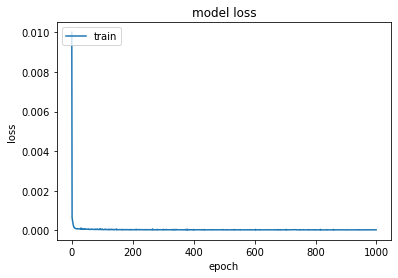

In [5]:
# Create and train the latitude predictor 
lat_model = Hurricane_Model(train_x,train_y_lat,test_x,test_y_lat,maxs[0],mins[0],"Latitude Model")
opt = tf.keras.optimizers.Adam()
lat_model.CreateModel(64,32,opt)
lat_model.TrainModel(0.8,1000,50)


In [6]:
lat_model.EvaluateModel()

Evaluating Model: Latitude Model
1787/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Shell Created: Longitude Model
Model Created: Longitude Model
Training Model: Longitude Model
Train on 6902 samples
Epoch 1/1000
6902/6902 [==============================] - 1s 103us/sample - loss: 0.0050 - mse: 0.0050 - mae: 0.0403
Epoch 2/1000
6902/6902 [==============================] - 0s 55us/sample - loss: 4.7222e-04 - mse: 4.7222e-04 - mae: 0.0163
Epoch 3/1000
6902/6902 [==============================] - 0s 56us/sample - loss: 3.8306e-04 - mse: 3.8306e-04 - mae: 0.0147
Epoch 4/1000
6902/6902 [==============================] - 0s 54us/sample - loss: 3.0910e-04 - mse: 3.0910e-04 - mae: 0.0132
Epoch 5/1000
6902/6902 [==============================] - 0s 55us/sample - loss: 2.5155e-04 - mse: 2.5155e-04 - mae: 0.0120
Epoch 6/1000
6902/6902 [==============================] - 0s 56us/sample - loss: 1.9841e-04 - mse: 1.9841e-04 - mae: 0.0107
Epoch 7/1000
6902/6902 [==============================] - 0s 54us/sample - loss: 1.6401e-04 - mse: 1.6401e-04 - mae: 0.0097
Epoch 8/1000
6902/6902 

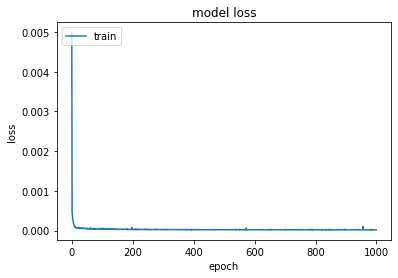

In [7]:
# Create and train the longitude predictor 
long_model = Hurricane_Model(train_x,train_y_long,test_x,test_y_long,maxs[1],mins[1],"Longitude Model")
opt = tf.keras.optimizers.Adam()
long_model.CreateModel(64,32,opt)
long_model.TrainModel(0.8,1000,50)

In [8]:
long_model.EvaluateModel()

Evaluating Model: Longitude Model
1787/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Shell Created: Wind Model
Model Created: Wind Model
Training Model: Wind Model
Train on 6902 samples
Epoch 1/1000
6902/6902 [==============================] - 1s 103us/sample - loss: 0.0280 - mse: 0.0280 - mae: 0.1020
Epoch 2/1000
6902/6902 [==============================] - 0s 51us/sample - loss: 0.0019 - mse: 0.0019 - mae: 0.0320
Epoch 3/1000
6902/6902 [==============================] - 0s 57us/sample - loss: 0.0016 - mse: 0.0016 - mae: 0.0297
Epoch 4/1000
6902/6902 [==============================] - 0s 56us/sample - loss: 0.0016 - mse: 0.0016 - mae: 0.0290
Epoch 5/1000
6902/6902 [==============================] - 0s 57us/sample - loss: 0.0015 - mse: 0.0015 - mae: 0.0281
Epoch 6/1000
6902/6902 [==============================] - 0s 54us/sample - loss: 0.0014 - mse: 0.0014 - mae: 0.0277
Epoch 7/1000
6902/6902 [==============================] - 0s 54us/sample - loss: 0.0014 - mse: 0.0014 - mae: 0.0273
Epoch 8/1000
6902/6902 [==============================] - 0s 55us/sample - loss: 0.001

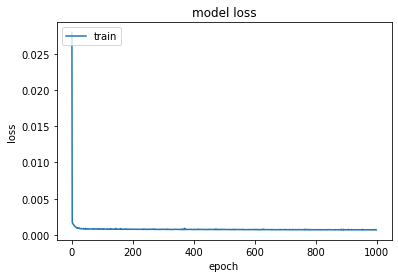

In [9]:
# Create and train the wind predictor
wind = 2
wind_model = Hurricane_Model(train_x,train_y_wind,test_x,test_y_wind,maxs[wind],mins[wind],"Wind Model")
opt = tf.keras.optimizers.Adam()
wind_model.CreateModel(32,16,opt)
wind_model.TrainModel(0.8,1000,50)

In [10]:
wind_model.EvaluateModel()

Evaluating Model: Wind Model
1787/1 [===================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Shell Created: Pressure Model
Model Created: Pressure Model
Training Model: Pressure Model
Train on 6902 samples
Epoch 1/1000
6902/6902 [==============================] - 1s 104us/sample - loss: 0.0191 - mse: 0.0191 - mae: 0.0823
Epoch 2/1000
6902/6902 [==============================] - 0s 56us/sample - loss: 0.0015 - mse: 0.0015 - mae: 0.0287
Epoch 3/1000
6902/6902 [==============================] - 0s 50us/sample - loss: 0.0010 - mse: 0.0010 - mae: 0.0227
Epoch 4/1000
6902/6902 [==============================] - 0s 53us/sample - loss: 9.4523e-04 - mse: 9.4523e-04 - mae: 0.0217
Epoch 5/1000
6902/6902 [==============================] - 0s 54us/sample - loss: 8.6300e-04 - mse: 8.6300e-04 - mae: 0.0205
Epoch 6/1000
6902/6902 [==============================] - 0s 51us/sample - loss: 9.0227e-04 - mse: 9.0227e-04 - mae: 0.0214
Epoch 7/1000
6902/6902 [==============================] - 0s 57us/sample - loss: 8.3341e-04 - mse: 8.3341e-04 - mae: 0.0203
Epoch 8/1000
6902/6902 [==================

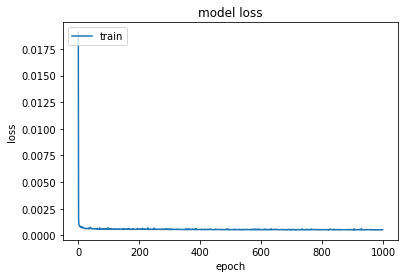

In [11]:
# Create and train the pressure predictor
pressure = 3
pres_model = Hurricane_Model(train_x,train_y_pres,test_x,test_y_pres,maxs[pressure],mins[pressure],"Pressure Model")
opt = tf.keras.optimizers.Adam()
pres_model.CreateModel(32,16,opt)
pres_model.TrainModel(0.8,1000,50)

In [12]:
pres_model.EvaluateModel()

Evaluating Model: Pressure Model
1787/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
# Use the 4 trained models to create the meta model
MetaModel = Meta_Model(lat_model,long_model,wind_model,pres_model)


In [14]:
# Get metrics on the metamodel
index = int(len(sorted_storms) *0.80)
testing_48h = sorted_storms[index:]
storms24h,labels24h = create_48h_of_storm_data(testing_48h)
MetaModel.EvaluateModel(storms24h[:750],labels24h[:750])

--------------------
6h MSE: 0.0002754229184979777
6h MAE: 0.01060449106778572

12h MSE: 0.0009689600695935962
12h MAE: 0.0216517114846976

18h MSE: 0.0021520282304662414
18h MAE: 0.03441612692930484

24h MSE: 0.003961545080877128
24h MAE: 0.048681904521179105

Overall MSE: 0.001839489074858736
Overall MAE: 0.02883855850074182
--------------------


**Visualizations**

---



Black := input path

Blue  := Actual path

Red   := Predicted Path

In [30]:
demo_index = random.randint(0,len(storms24h)) # get the random storm segment
demo_x = storms24h[demo_index]
demo_y = labels24h[demo_index]

display(MetaModel.Visualize(demo_x,demo_y))

In [62]:
demo_index = random.randint(0,len(storms24h)) # get the random storm segment
demo_x = storms24h[demo_index]
demo_y = labels24h[demo_index]

display(MetaModel.Visualize(demo_x,demo_y))

In [61]:
demo_index = random.randint(0,len(storms24h)) # get the random storm segment
demo_x = storms24h[demo_index]
demo_y = labels24h[demo_index]

display(MetaModel.Visualize(demo_x,demo_y))